## Imports


In [1]:
# imports
import os
import shutil
import random
import kaggle
import torch
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np


## Prepare data

In [2]:
# paths
tmp_path = 'tmp'
train_dataset_path = f'{tmp_path}/train_dataset'
test_dataset_path = f'{tmp_path}/test_dataset'


In [3]:
# download dataset
if not os.path.exists(train_dataset_path) or not os.path.exists(test_dataset_path):
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files('grassknoted/asl-alphabet', path=tmp_path, unzip=True)

    shutil.move(f"{tmp_path}/asl_alphabet_train/asl_alphabet_train", train_dataset_path)
    shutil.move(f"{tmp_path}/asl_alphabet_test/asl_alphabet_test", test_dataset_path)

    shutil.rmtree(f"{tmp_path}/asl_alphabet_train")
    shutil.rmtree(f"{tmp_path}/asl_alphabet_test")


## Configure PyTorch


In [4]:
# PyTorch device
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

## Prepare data


In [5]:
# Define transform
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
transform


Compose(
    Resize(size=(200, 200), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [6]:
# Load dataset
dataset = datasets.ImageFolder(root=train_dataset_path, transform=transform)
dataset


Dataset ImageFolder
    Number of datapoints: 87000
    Root location: tmp/train_dataset
    StandardTransform
Transform: Compose(
               Resize(size=(200, 200), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [7]:
# Get classes
classes = dataset.classes
classes


['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

In [8]:
# Count classes
classes_count = len(classes)
classes_count


29

In [9]:
# Set train/test split ratio
train_ratio = 0.8
test_ratio = 0.2
{"train_ratio": train_ratio, "test_ratio": test_ratio}


{'train_ratio': 0.8, 'test_ratio': 0.2}

In [10]:
# Set train/test sizes
train_size = int(train_ratio * len(dataset))
test_size = int(test_ratio * len(dataset))
{"train_size": train_size, "test_size": test_size}


{'train_size': 69600, 'test_size': 17400}

In [11]:
# Split dataset into train and test
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


In [12]:
# Count train/test dataset sizes
train_dataset_count = len(train_dataset)
test_dataset_count = len(test_dataset)
{"train_dataset_count": train_dataset_count, "test_dataset_count": test_dataset_count}


{'train_dataset_count': 69600, 'test_dataset_count': 17400}

In [13]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)


In [14]:
# Display random images function
def show_random_samples(dataset, classes, num_samples=5):
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 15))

    for i in range(num_samples):
        index = np.random.randint(0, len(dataset) - 1)
        image, label = dataset[index]

        axs[i].imshow(image.permute(1, 2, 0))
        axs[i].set_title(classes[label])
        axs[i].axis('off')

    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


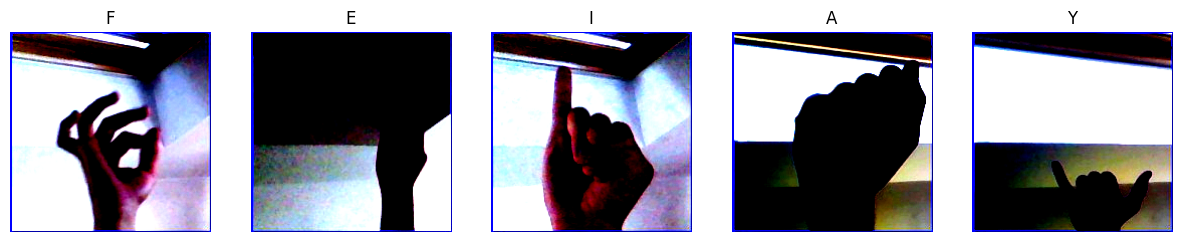

In [15]:
# Display random images from train dataset
show_random_samples(train_dataset, classes)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


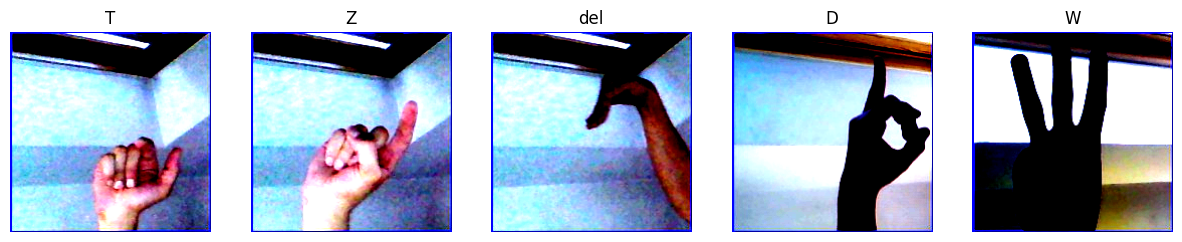

In [16]:
# Display random images from test dataset
show_random_samples(test_dataset, classes)


## Prepare models


### Custom


### AlexNet


### Vgg16


### Vgg19


### GoogleNet


### ResNet 18


### ResNet 50


### MobileNet V2


### MobileNet V3


## Train models


### Custom


### AlexNet


### Vgg16


### Vgg19


### GoogleNet


### ResNet 18


### ResNet 50


### MobileNet V2


### MobileNet V3


## Evaluate


### Custom


### AlexNet


### Vgg16


### Vgg19


### GoogleNet


### ResNet 18


### ResNet 50


### MobileNet V2


### MobileNet V3


## Test


### Custom


### AlexNet


### Vgg16


### Vgg19


### GoogleNet


### ResNet 18


### ResNet 50


### MobileNet V2


### MobileNet V3
